<h2>Video Style Transfer</h2>

In this notebook, a quick style transfer is done to a youtube video and an image. The output will be downloaded, so that you can watch it with your friends and share it online! Here is an example video!


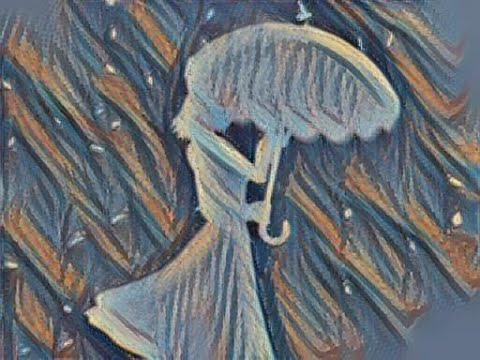

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('vdQPKob4DFI', width=800, height=300)

<h3>Non Python Stuff</h3>

We need a way to get the youtube video frames. Easiest method is to use <code>youtube-dl</code> to download the video and use <code>ffmpeg</code> to extract the frames. 

<h3>Conda Env Setup</h3>

This program is currently tested on Ubuntu with Python3.8.8, in a custom conda env. If this is your first time using conda enviroments, here is a basic walkthrough. Start with installing Anaconda. 

https://www.anaconda.com/

Once you have Anaconda installed, open a terminal and create a new conda enviroment for tensorflow. 

<code>conda create -n tf tensorflow</code>

Before activating the conda enviroment, we want to make sure we can use it on our notebook. The easy way to do this is to install nb conda kernels.

<code>conda install nb_conda_kernels</code> 

Now, activate your enviroment!

<code>conda activate tf</code>

Your module imports from now on, until you deactivate the enviroment, will be contained and version locked inside the enviroment, without disturbing other parts of your python installation. Machine learning tends to require specific versions of modules, to avoid running into incompatibility problems. To make sure we don't run into module version errors, lets install our modules by refering to their version. <code>youtube_dl</code> and <code>ffmpk</code> are for downloading youtube video, and extracting/stacking frames, respectively. 

<code>conda install tensorflow==2.6.0
conda install tensorflow-hub==0.12.0
conda install ipykernel==6.4.1
pip install youtube_dl
pip install ffmpy</code>

Now, the enviroment should be ready to use! I like to use one last modification to detect memory issues; machine learning is extremely memory intensive and can crash your computer if not managed properly. To see the memory usage of the notebook itself, add the jupyter resource usage widget. 

<code>conda install -c conda-forge jupyter-resource-usage</code>

Now, lets check all of our imports to make sure they work properly! A noncritical error may occur, but can be ignored.

In [2]:
%%capture
import os
import tensorflow as tf
import tensorflow_hub as hub
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
#arbitrary image stylization model load
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

import IPython.display as display

#displays images when needed
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
plt.axis('off')

import numpy as np
import PIL.Image
import time
import functools
import glob 

from __future__ import unicode_literals
import youtube_dl
import ffmpy
import shutil

2021-10-29 01:26:37.616941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-29 01:26:37.616957: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-29 01:26:38.942558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-29 01:26:38.942592: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-29 01:26:38.942607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (NewRed): /proc/driver/nvidia/version does not exist
2021-10-29 01:26:38.942756: I tensorflow/core/platform/cpu_feature_gua

<h3>Functions</h3>

Some functions used to generate the video:

In [3]:
def tensor_to_image(tensor):
  '''Converts a tensor to an image.'''
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  '''Loads an image from temp storage, following a path.'''
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  '''Displays imaged with plt. Use sparingly, as this function eats memory fast.'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


<h3>Video and Style Image Selection</h3>

Here, we select a fun image to use for the style: Girl with a Mandolin by Picasso! Wikipedia is a great source of style images. 


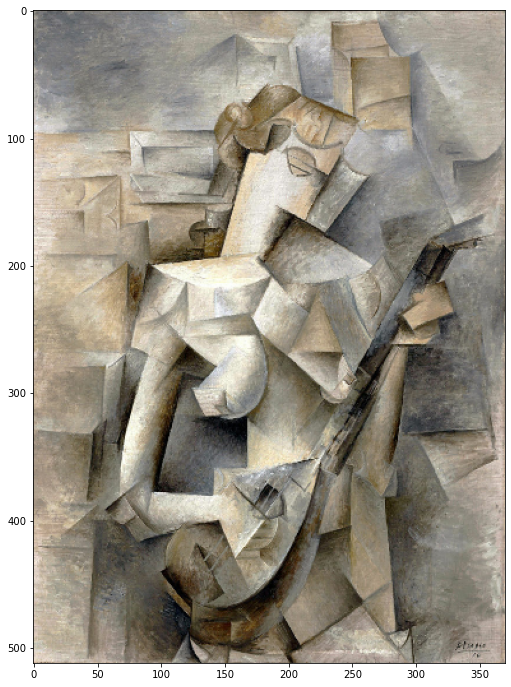

In [4]:
style_path = tf.keras.utils.get_file('cubist.jpg', 'https://upload.wikimedia.org/wikipedia/en/thumb/1/1c/Pablo_Picasso%2C_1910%2C_Girl_with_a_Mandolin_%28Fanny_Tellier%29%2C_oil_on_canvas%2C_100.3_x_73.6_cm%2C_Museum_of_Modern_Art_New_York..jpg/800px-Pablo_Picasso%2C_1910%2C_Girl_with_a_Mandolin_%28Fanny_Tellier%29%2C_oil_on_canvas%2C_100.3_x_73.6_cm%2C_Museum_of_Modern_Art_New_York..jpg')
style_image = load_img(style_path)
imshow(style_image)

youtube_link = 'https://www.youtube.com/watch?v=BaW_jenozKc'#'https://www.youtube.com/watch?v=dQw4w9WgXcQ'

<h2>Data Download and Preparation</h2>

Here, we gather up the data from youtube and process it down for tensorflow to crunch on. First, youtube-dl downloads the video and audio from the link. Then, all of the frames are extracted to a temporary folder for frames. 

Finally, all frames will be run through the model to apply style transfer. I have this as a separate cell, because it takes considerably longer than everything else in this notebook.

[youtube] BaW_jenozKc: Downloading webpage
[download] Destination: Recording.f137.mp4
[download] 100% of 2.11MiB in 00:3411KiB/s ETA 00:00
[download] Destination: Recording.mp4.f140
[download] 100% of 154.06KiB in 00:0299KiB/s ETA 00:00
[ffmpeg] Merging formats into "Recording.mp4"
Deleting original file Recording.f137.mp4 (pass -k to keep)
Deleting original file Recording.mp4.f140 (pass -k to keep)
[youtube] BaW_jenozKc: Downloading webpage
[download] Destination: Recording.mp3
[download] 100% of 154.06KiB in 00:0239KiB/s ETA 00:00
[ffmpeg] Correcting container in "Recording.mp3"
[ffmpeg] Post-process file Recording.mp3 exists, skipping


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

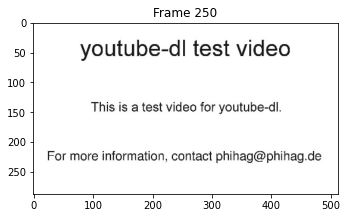

In [5]:
#creates fresh tempframes folder
temppath = r'tempframes' 
if not os.path.exists(temppath):
    os.makedirs(temppath)
else:
    shutil.rmtree(temppath)
    os.makedirs(temppath)

#download video as mp4
ydl = youtube_dl.YoutubeDL({'outtmpl': 'Recording.mp4'})
ydl.add_default_info_extractors()
ydl.download([youtube_link])

#download audio as mp3
ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
    }],
    'outtmpl': 'Recording.mp3'
}
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([youtube_link])
    
#extracts all frames from video as jpg
ff = ffmpy.FFmpeg(
    inputs={'Recording.mp4': None},
    outputs={r'tempframes/%06d.jpg': None},
    )
ff.run()

#sanity check to display a frame. Any vid shorter than 10 seconds may not have this frame!
sanity_check_path = 'tempframes/000250.jpg'
sanity_check_image = load_img(sanity_check_path)

plt.subplot(1, 2, 1)
imshow(sanity_check_image, 'Frame 250')

#create list of image file names
imagelist = sorted(glob.glob("tempframes/*"))

In [6]:
#define a function to loop through a list of files
def quickStyle(imageList):
    '''Stylize the images listed in an imagelist.
    Prints a time per image and frame number.
    Usually takes about .8 seconds per frame, 
    but may take more or less depending on system.'''
    for i, j in enumerate(imageList):
        print(i)
        start = time.time()
        content_image = load_img(j)
        stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
        tensor_to_image(stylized_image).save(r'tempresults/'+str(i).zfill(6)+'.jpg')
        del(stylized_image)
        del(content_image)
        end = time.time()
        print(end - start)

#creates fresh results folder
temppath = r'tempresults' 
if not os.path.exists(temppath):
    os.makedirs(temppath)
else:
    shutil.rmtree(temppath)
    os.makedirs(temppath)

quickStyle(imagelist)


0


2021-10-29 01:27:24.503634: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.286336898803711
1
0.5825316905975342
2
0.5537278652191162
3
0.5538651943206787
4
0.5497951507568359
5
0.5486166477203369
6
0.5441973209381104
7
0.5491542816162109
8
0.546682596206665
9
0.5484418869018555
10
0.5474436283111572
11
0.5477492809295654
12
0.5532772541046143
13
0.5487134456634521
14
0.5521109104156494
15
0.5461757183074951
16
0.5511252880096436
17
0.545419454574585
18
0.5472028255462646
19
0.5546112060546875
20
0.551072359085083
21
0.5507795810699463
22
0.5454344749450684
23
0.5492181777954102
24
0.5476341247558594
25
0.5488193035125732
26
0.5446157455444336
27
0.5563297271728516
28
0.5544857978820801
29
0.5501601696014404
30
0.5544126033782959
31
0.5475723743438721
32
0.5455837249755859
33
0.5480279922485352
34
0.5474975109100342
35
0.5484206676483154
36
0.5642924308776855
37
0.549534797668457
38
0.5463471412658691
39
0.5528028011322021
40
0.5486092567443848
41
0.5489871501922607
42
0.547980785369873
43
0.5508699417114258
44
0.5484483242034912
45
0.5486483573913574
46
0.5

<h3>Recombining and Applying Audio</h3>

Now that the style transfer is complete, all that is left is putting the video together and throwing out trash frames.


In [7]:
#remove previous output to prevent error
if os.path.isfile('output.mp4'):
    os.remove('output.mp4')

#stack all frames from frames to video
ff = ffmpy.FFmpeg(
    inputs={'tempresults/%06d.jpg': None},
    outputs={'styled.mp4': None},
    )
ff.run()

#stack all frames from frames to video
ff = ffmpy.FFmpeg(
    inputs={'styled.mp4': None,
           'Recording.mp3': None},
    outputs={'output.mp4': None},
    )
ff.run()

#clean up unneeded files
os.remove('styled.mp4')
os.remove('Recording.mp4')
os.remove('Recording.mp3')

temppath = r'tempresults' 
shutil.rmtree(temppath)
temppath = r'tempframes'
shutil.rmtree(temppath)



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

frame=  294 fps=0.0 q=-1.0 Lsize=     590kB time=00:00:11.64 bitrate= 415.5kbits/s speed=25.4x    
video:423kB audio:157kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.724535%
[libx264 @ 0x556d2cc06040] frame I:2     Avg QP:20.53  size: 27744
[libx264 @ 0x556d2cc06040] frame P:95    Avg QP:22.09  size:  3611
[libx264 @ 0x556d2cc06040] frame B:197   Avg QP:27.26  size:   174
[libx264 @ 0x556d2cc06040] consecutive B-frames:  1.7% 25.9%  3.1% 69.4%
[libx264 @ 0x556d2cc06040] mb I  I16..4:  0.2% 99.7%  0.1%
[libx264 @ 0x556d2cc06040] mb P  I16..4:  0.1%  1.4%  0.0%  P16..4: 31.3% 11.2% 13.3%  0.0%  0.0%    skip:42.6%
[libx264 @ 0x556d2cc06040] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8: 18.6%  0.6%  0.1%  direct: 0.2%  skip:80.4%  L0:45.5% L1:51.9% BI: 2.6%
[libx264 @ 0x556d2cc06040] 8x8 transform intra:97.8% inter:88.5%
[libx264 @ 0x556d2cc06040] coded y,uvDC,uvAC intra: 94.1% 93.5% 51.2% inter: 12.8% 7.2% 0.2%
[libx264 @ 0x556d2cc06040] i16 v,h,dc,p: 42%  0% 40% 18%


In [8]:
from IPython.display import Video
print('Finished processing!')
Video("output.mp4")

Finished processing!
